![spotify_logo](../assets/Spotify_Logo_CMYK_Green.png)

# Spotify Skip Prediction: Feature Engineering and Modelling - Exponentially-Weighed Moving Average of Session Features
Notebook: 5 of 7

Author: Alex Thach - alcthach@gmail.com  
BrainStation Data Science Capstone Project - Winter 2022  
April 4, 2022
---

# Recap
- I moved on from the baseline feature engineering and modelling from the previous notebook, and looked to explore the outcome of encoding session characteristics into a single observation
- Instead of a single row in the data representing the song characteristics and how the user interacted with the song, I wanted to capture the aggregrate characteristics of the session at that point in time
- I successfully transformed the dataset, and minimized the threat of data leakage by staggering skip and track end behaviours by one observation (or song)
- In general the model performed worse than the baseline model from the last notebook, this is likely due to the equal weighting of each observation 
- **So far in the project, the findings seem to suggest that previous user interaction history, and weighing of this history appear to have an important effect on predicting skip outcomes of each track**

# Purpose: 
The goal of this notebook is continue with a final run of feature engineering and modelling experiments. I will aim to engineering a feature that encodes aggregate user interaction and track features with a weighing towards the most recent time period.

---

# Summary/Highlights:
- Successfully transformed the features to an exponentially-weight moving area
- In which a single observation in the dataset provides aggregrate information about the session, weight more towards the current song
- Rather than equally weighting all characteristics during each track position in a listening session
- I converged on an alpha parameter of 0.7 to compute the exponentially-weighted moving average
- At the end of this notebook, I trained Random Forest Classifier on the optimized EWMA-transformed data, yielding a mean cross-validation (5-fold) score of 78%

---

In [1]:
# Runs setup script, imports, plotting settings, reads in raw data
%run -i "../scripts/at-setup.py" 

Dataframes in the global name space now include:
session_logs_df
track_features_df


In [2]:
# Reads in data
main_df = pd.read_csv('../data/processed/merged.csv')
features = pd.read_csv('../data/processed/features.csv')
target = pd.read_csv('../data/processed/target.csv')

## Exponentially-weight moving average: Capturing aggregate user interaction and track features with optimal weighting 

- To properly capture aggregrate characteristics of a listening session I will employ an exponentially-weighted moving average (EWMA)
- In essence, this is a moving average that weighs the next observation more heavily in its calculations of the moving average
- I will employ a similar methodology as seen in the previous notebook while computing cumulative average
    - The coding patterns will look similar but I will call the `'.ewm()'` method from pandas to help me calculate the EWMA
    - We will choose an arbitrary alpha parameter (smoothing factor) of 0.5, which determines the weighting in the the calculations
    - Following which I will optimize for this parameter

In [3]:
# Assigns variables prior to feature engineering
X1 = features
y = target

In [4]:
# Computes the cumulative average of features for all listening sessions in the dataset
X1.groupby('session_id', as_index=True).ewm(alpha = 0.5).mean().reset_index().drop('level_1', axis=1)

,session_id,session_position,session_length,skip_2,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,...,enc__hist_user_behavior_reason_start_trackerror,enc__hist_user_behavior_reason_end_backbtn,enc__hist_user_behavior_reason_end_clickrow,enc__hist_user_behavior_reason_end_endplay,enc__hist_user_behavior_reason_end_fwdbtn,enc__hist_user_behavior_reason_end_logout,enc__hist_user_behavior_reason_end_remote,enc__hist_user_behavior_reason_end_trackdone,enc__mode_major,enc__mode_minor
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1.000000,20.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,1.000000,0.000000
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1.666667,20.0,0.000000,0.0,0.666667,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.333333,0.666667
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2.428571,20.0,0.000000,0.0,0.857143,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.714286,0.285714
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3.266667,20.0,0.000000,0.0,0.933333,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.866667,0.133333
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4.161290,20.0,0.000000,0.0,0.967742,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.000000,0.935484,0.064516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167875,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,15.000244,20.0,0.062501,0.0,0.937453,0.000031,0.062531,0.0,0.0,...,0.0,0.0,0.0,0.0,0.062501,0.0,0.0,0.937499,0.499321,0.500679
167876,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,16.000130,20.0,0.031250,0.0,0.968727,0.000015,0.031265,0.0,0.0,...,0.0,0.0,0.0,0.0,0.031250,0.0,0.0,0.968750,0.249659,0.750341
167877,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,17.000069,20.0,0.015625,0.0,0.984363,0.000008,0.015633,0.0,0.0,...,0.0,0.0,0.0,0.0,0.015625,0.0,0.0,0.984375,0.624831,0.375169
167878,0_0eaeef5d-25e9-4429-bd55-af15d3604c9f,18.000036,20.0,0.007813,0.0,0.992182,0.000004,0.007816,0.0,0.0,...,0.0,0.0,0.0,0.0,0.007813,0.0,0.0,0.992187,0.312415,0.687585


In [5]:
%%time
# Will take ~7-8 seconds to run
# Calculates the EWMA for features in each listening session
# Resets index
# Drops 'level_1' column
X1 = features.groupby('session_id', as_index=False).ewm(alpha = 0.66).mean().reset_index().drop('level_1', axis=1)

# Assigns to X_shifted, will be re-assigned to original dataframe
X1_shifted = X1.groupby('session_id')[['skip_2',   
                                            'enc__hist_user_behavior_reason_end_backbtn',
                                            'enc__hist_user_behavior_reason_end_clickrow',  
                                            'enc__hist_user_behavior_reason_end_endplay',  
                                            'enc__hist_user_behavior_reason_end_fwdbtn',  
                                            'enc__hist_user_behavior_reason_end_logout',
                                            'enc__hist_user_behavior_reason_end_remote',  
                                            'enc__hist_user_behavior_reason_end_trackdone']].shift()

# Re-assigns previous columns to shift columns from above
X1 = X1.assign(**X1_shifted.to_dict(orient='series'))

# Re-assigns 'session_position' to original value Re: I require the original values so that the model has information about where the track is within the session
X1['session_position'] = features['session_position']

Wall time: 8.64 s


Notes on the transformation above:
- `'groupby('session_id')'` was employed to calculate the EWMA average of each feature in the listening session
- After EWMA was calculated, the `'skip_2'` and track end behaviour columns were shifted down a row 
    - If you recall from the previous notebook, I was faced with some data leakage related to both `'skip_2'` and track end behaviour
    - `'skip_2'`  was obvious, but the data leakage caused by the track end behaviours was a bit more nuanced
    - By shifting the columns down by one row, the current observation is now blind to what it's own skip and track end behaviour, and now sees the EWMA for these features, not include the current track
    - In other words, the observation stores information about the EWMA in skip and track end behaviours, on average, how much has the user been skipped, or how have the tracks been ending?
- Next I reassigned the `'session_position'` values, to return the column back to the original values, which helps me to maintain the sequential information in the dataset
- Finally, I dropped `'session_id'` as this is the final version of the transform dataset, with EWMA as a feature

In [6]:
# Prints table summary
X1[X1['session_id'] == '0_00006f66-33e5-4de7-a324-2d18e439fc1e'][['skip_2']]

,skip_2
0,NaN
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.660347
8,0.884558
9,0.960754


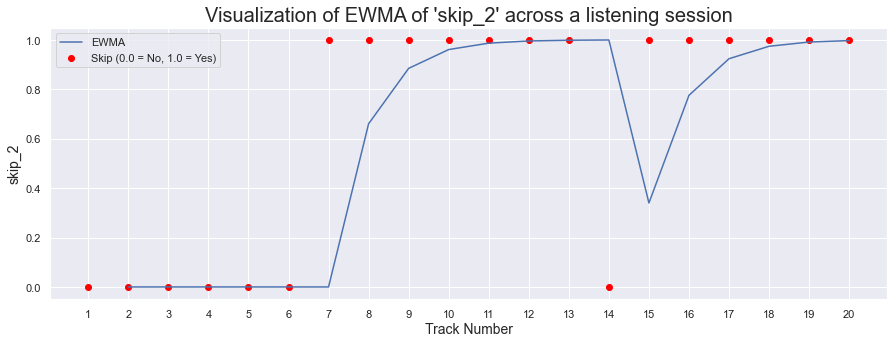

In [7]:
# New index to shift EWMA plot to reflect a lag
new_index = X1[X1['session_id'] == '0_00006f66-33e5-4de7-a324-2d18e439fc1e']['skip_2'].index + 1

# Plots 'skip_2' and its EWMA
plt.figure()
plt.plot(X1[X1['session_id'] == '0_00006f66-33e5-4de7-a324-2d18e439fc1e'][['skip_2']].set_index(new_index), label='EWMA')
plt.scatter(main_df[main_df['session_id'] == '0_00006f66-33e5-4de7-a324-2d18e439fc1e']['session_position'],
            main_df[main_df['session_id'] == '0_00006f66-33e5-4de7-a324-2d18e439fc1e']['skip_2'], color = 'red', label = 'Skip (0.0 = No, 1.0 = Yes)')
plt.title("Visualization of EWMA of 'skip_2' across a listening session")
plt.xlabel('Track Number')
plt.ylabel('skip_2')
plt.legend()
plt.xticks(main_df[main_df['session_id'] == '0_00006f66-33e5-4de7-a324-2d18e439fc1e']['session_position'])
plt.savefig('skip2_emwa.png')

The figure above highlights a stark difference between what we saw in the previous notebook with cumulative average. We can see that the EWMA is more responsive to changes in session behaviour. By weighing observations towards the present time. We get information about the most immediate characteristics of the session, rather than equally weighting each point in time during the listening session. This will be interesting to consider when I train a model on this data.

---

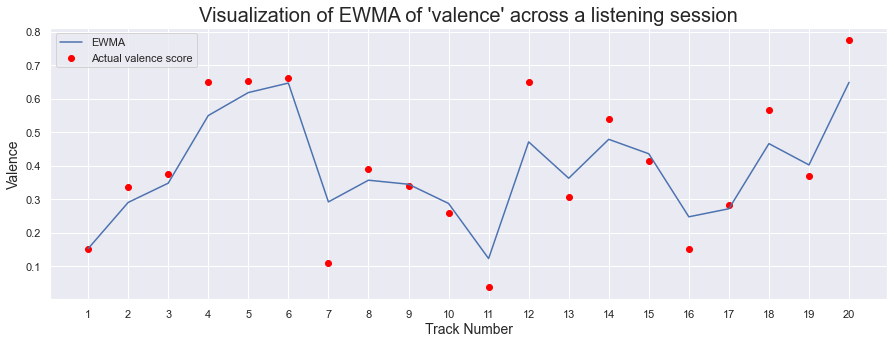

In [8]:
# Lines up the EWMA plot
new_index = X1[X1['session_id'] == '0_00006f66-33e5-4de7-a324-2d18e439fc1e']['skip_2'].index + 1

# Plots 'valence' and its EWMA
plt.figure()
plt.plot(X1[X1['session_id'] == '0_00006f66-33e5-4de7-a324-2d18e439fc1e'][['valence']].set_index(new_index), label=('EWMA'))
plt.scatter(main_df[main_df['session_id'] == '0_00006f66-33e5-4de7-a324-2d18e439fc1e']['session_position'],
            main_df[main_df['session_id'] == '0_00006f66-33e5-4de7-a324-2d18e439fc1e']['valence'], color = 'red', label = 'Actual valence score')
plt.title("Visualization of EWMA of 'valence' across a listening session")
plt.xlabel('Track Number')
plt.ylabel('Valence')
plt.legend()
plt.xticks(main_df[main_df['session_id'] == '0_00006f66-33e5-4de7-a324-2d18e439fc1e']['session_position'])
plt.show()

The figure above provides another example of how the EWMA tries to capture the aggregate characteristics of the session. In this case, valence. 

---

### Modelling using EWMA

In [9]:
# Drops 'session_id' column
X1.drop('session_id', axis=1, inplace=True)

Quick check to see the data I'm working with

In [10]:
X1.head()

,session_position,session_length,skip_2,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,...,enc__hist_user_behavior_reason_start_trackerror,enc__hist_user_behavior_reason_end_backbtn,enc__hist_user_behavior_reason_end_clickrow,enc__hist_user_behavior_reason_end_endplay,enc__hist_user_behavior_reason_end_fwdbtn,enc__hist_user_behavior_reason_end_logout,enc__hist_user_behavior_reason_end_remote,enc__hist_user_behavior_reason_end_trackdone,enc__mode_major,enc__mode_minor
0,1,20.0,NaN,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
1,2,20.0,0.0,0.0,0.746269,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.253731,0.746269
2,3,20.0,0.0,0.0,0.920583,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.766419,0.233581
3,4,20.0,0.0,0.0,0.973708,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.922671,0.077329
4,5,20.0,0.0,0.0,0.991140,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.973941,0.026059


In [11]:
y.head()

,skip_2
0,False
1,False
2,False
3,False
4,False


### Modelling New Feature with Logit Classifier 
**Note: The third code cell below this heading will throw an error, proceed to run the cells afterwards to resolve.**

In [12]:
# Splitting into remainder and test sets
X1_remainder, X1_test, y1_remainder, y1_test = \
    train_test_split(X1, y, test_size = 0.2,
                     random_state=42)

In [13]:
# Splitting the remainder into train and validation
X1_train, X1_validation, y1_train, y1_validation = \
    train_test_split(X1_remainder, y1_remainder, test_size = 0.3,
                     random_state=42)

In [14]:
# Instantiates Logit
logit = LogisticRegression(max_iter=500, verbose=1, n_jobs=-1)

# Fits
logit.fit(X1_train, y1_train)

# Scores on train and validation
print(logit.score(X1_train, y1_train))
print(logit.score(X1_validation, y1_validation))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

There are NaNs in the data. This was caused by the column staggers I employed to reduce the likelihood of data leakage. I'll make an important assumption here. I'll begin the predictions at the second track of every session. Rather than at the first track. 

In [15]:
X1[X1['session_position'] == 1]

,session_position,session_length,skip_2,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,...,enc__hist_user_behavior_reason_start_trackerror,enc__hist_user_behavior_reason_end_backbtn,enc__hist_user_behavior_reason_end_clickrow,enc__hist_user_behavior_reason_end_endplay,enc__hist_user_behavior_reason_end_fwdbtn,enc__hist_user_behavior_reason_end_logout,enc__hist_user_behavior_reason_end_remote,enc__hist_user_behavior_reason_end_trackdone,enc__mode_major,enc__mode_minor
0,1,20.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
20,1,20.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
40,1,20.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
60,1,20.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
80,1,11.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167788,1,20.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
167808,1,20.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
167828,1,20.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
167848,1,12.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0


The cell output above returns each of the first tracks in every listening session in the dataset. If you remember, I had shifted the `'skip_2'` to prevent data leakage. As a result I cannot predict first track skip due to the presence of missing values. An assumption I'll make here is that I will begin predictions at the second track. So we'll remove the first tracks from the dataset.

In [16]:
# Sanity check, seeing what the mask used for dropping first tracks looks like
X1[X1['session_position'] == 1].index

Int64Index([     0,     20,     40,     60,     80,     91,    106,    121,
               141,    161,
            ...
            167702, 167722, 167742, 167754, 167774, 167788, 167808, 167828,
            167848, 167860],
           dtype='int64', length=10000)

This means the target variable also needs to be transformed.

In [17]:
# Drops first songs in target variable using the mask from dropping first songs in X1
y.drop(X1[X1['session_position'] == 1].index, inplace=True)

In [18]:
# Drops the first song of each listening session
X1.drop(X1[X1['session_position'] == 1].index, inplace=True)

In [19]:
# Sanity check
X1.head()

,session_position,session_length,skip_2,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,...,enc__hist_user_behavior_reason_start_trackerror,enc__hist_user_behavior_reason_end_backbtn,enc__hist_user_behavior_reason_end_clickrow,enc__hist_user_behavior_reason_end_endplay,enc__hist_user_behavior_reason_end_fwdbtn,enc__hist_user_behavior_reason_end_logout,enc__hist_user_behavior_reason_end_remote,enc__hist_user_behavior_reason_end_trackdone,enc__mode_major,enc__mode_minor
1,2,20.0,0.0,0.0,0.746269,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.253731,0.746269
2,3,20.0,0.0,0.0,0.920583,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.766419,0.233581
3,4,20.0,0.0,0.0,0.973708,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.922671,0.077329
4,5,20.0,0.0,0.0,0.991140,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.973941,0.026059
5,6,20.0,0.0,0.0,0.996997,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.330145,0.669855


In [20]:
# Another sanity check to insure the indices match
all(X1.index == y.index)

True

In [21]:
# Re-assigns y to correct dimensions
y = y['skip_2']

Now that I successfully dropped the first tracks of each session from both X1, and y, I will proceed to fit a Logit classifier to see how the new engineered feature performs.

In [22]:
# Splitting into remainder and test sets
X1_remainder, X1_test, y1_remainder, y1_test = \
    train_test_split(X1, y, test_size = 0.2,
                     random_state=42)

In [23]:
# Splitting the remainder into train and validation
X1_train, X1_validation, y1_train, y1_validation = \
    train_test_split(X1_remainder, y1_remainder, test_size = 0.3,
                     random_state=42)

In [24]:
# Instantiates Logit
logit = LogisticRegression(max_iter=500, verbose=1, n_jobs=-1, random_state=42)

# Fits (Estimated runtime: ~1-2 min)
logit.fit(X1_train, y1_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.5min finished


LogisticRegression(max_iter=500, n_jobs=-1, random_state=42, verbose=1)

In [25]:
# Scores on train and validation
print(f"Train score: {logit.score(X1_train, y1_train):.2f}")
print(f"Validation score: {logit.score(X1_validation, y1_validation):.2f}")

Train score: 0.76
Validation score: 0.76


Based on these results, this model is comparable to the baseline model I trained in Notebook 4. Which had a classication accuracy of 77%. It should be noted that the EWMA was computed using alpha = 0.5. I'll now move on to try and optimize for alpha.

---

### Optimizing for `'alpha'`

### Using Logistic Regression

In [26]:
# Warning this cell will take a while to run roughly 10-20 minutes

# Assigning X
X = features

# Creates range of alpha values to iterate through
alpha_range = np.linspace(0.1, 0.9, 9).round(1) 

# Instantiates dictionary to store alpha parameter and respective accuracies from model
alpha_acc_dict = {}

# Pre-populates with keys from alpha_range
for i in alpha_range:
    alpha_acc_dict[i] = []

for alpha in alpha_range:
    
    print("Computing exponentially-weighted moving average for features.")
    X2 = X.groupby('session_id', as_index=False).ewm(alpha = alpha).mean().reset_index().drop('level_1', axis=1)

    # Assigns to X_shifted, will be re-assigned to original dataframe
    X2_shifted = X2.groupby('session_id')[['skip_2',   
                                                'enc__hist_user_behavior_reason_end_backbtn',
                                                'enc__hist_user_behavior_reason_end_clickrow',  
                                                'enc__hist_user_behavior_reason_end_endplay',  
                                                'enc__hist_user_behavior_reason_end_fwdbtn',  
                                                'enc__hist_user_behavior_reason_end_logout',
                                                'enc__hist_user_behavior_reason_end_remote',  
                                                'enc__hist_user_behavior_reason_end_trackdone']].shift()
    

    # Re-assigns previous columns to shift columns from above
    print("Implementing row stagger for skip and track end behaviour features.")

    X2 = X2.assign(**X2_shifted.to_dict(orient='series'))

    # Re-assigns 'session_position' to original value Re: I require the original values so that the model has information about where the track is within the session
    print("Re-assigning original 'session_position' feature values.")
    X2['session_position'] = X['session_position']

    # Drops first song from every session
    print("Dropping first song from every session.")
    X2.drop(X2[X2['session_position'] == 1].index, inplace=True)
    
    # Drops 'session_id' column
    print("Dropping 'session_id' column.")
    X2.drop('session_id', axis=1, inplace=True)
    
    estimators = [('normalise', StandardScaler()),
                    ('logit', LogisticRegression(n_jobs= -1, random_state=42, max_iter=500))] 

    pipe = Pipeline(estimators)
    
    print("Calculating model score.")
    
    mean_cross_val_score = np.mean(cross_val_score(pipe, X2, y, cv=3, verbose=1))
    
    print("Appending score to dictionary.")
    alpha_acc_dict[alpha].append(mean_cross_val_score)

Computing exponentially-weighted moving average for features.
Implementing row stagger for skip and track end behaviour features.
Re-assigning original 'session_position' feature values.
Dropping first song from every session.
Dropping 'session_id' column.
Calculating model score.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   53.8s finished


Appending score to dictionary.
Computing exponentially-weighted moving average for features.
Implementing row stagger for skip and track end behaviour features.
Re-assigning original 'session_position' feature values.
Dropping first song from every session.
Dropping 'session_id' column.
Calculating model score.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   55.5s finished


Appending score to dictionary.
Computing exponentially-weighted moving average for features.
Implementing row stagger for skip and track end behaviour features.
Re-assigning original 'session_position' feature values.
Dropping first song from every session.
Dropping 'session_id' column.
Calculating model score.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   51.0s finished


Appending score to dictionary.
Computing exponentially-weighted moving average for features.
Implementing row stagger for skip and track end behaviour features.
Re-assigning original 'session_position' feature values.
Dropping first song from every session.
Dropping 'session_id' column.
Calculating model score.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   46.8s finished


Appending score to dictionary.
Computing exponentially-weighted moving average for features.
Implementing row stagger for skip and track end behaviour features.
Re-assigning original 'session_position' feature values.
Dropping first song from every session.
Dropping 'session_id' column.
Calculating model score.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   46.9s finished


Appending score to dictionary.
Computing exponentially-weighted moving average for features.
Implementing row stagger for skip and track end behaviour features.
Re-assigning original 'session_position' feature values.
Dropping first song from every session.
Dropping 'session_id' column.
Calculating model score.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   46.4s finished


Appending score to dictionary.
Computing exponentially-weighted moving average for features.
Implementing row stagger for skip and track end behaviour features.
Re-assigning original 'session_position' feature values.
Dropping first song from every session.
Dropping 'session_id' column.
Calculating model score.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   45.9s finished


Appending score to dictionary.
Computing exponentially-weighted moving average for features.
Implementing row stagger for skip and track end behaviour features.
Re-assigning original 'session_position' feature values.
Dropping first song from every session.
Dropping 'session_id' column.
Calculating model score.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   47.9s finished


Appending score to dictionary.
Computing exponentially-weighted moving average for features.
Implementing row stagger for skip and track end behaviour features.
Re-assigning original 'session_position' feature values.
Dropping first song from every session.
Dropping 'session_id' column.
Calculating model score.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Appending score to dictionary.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished


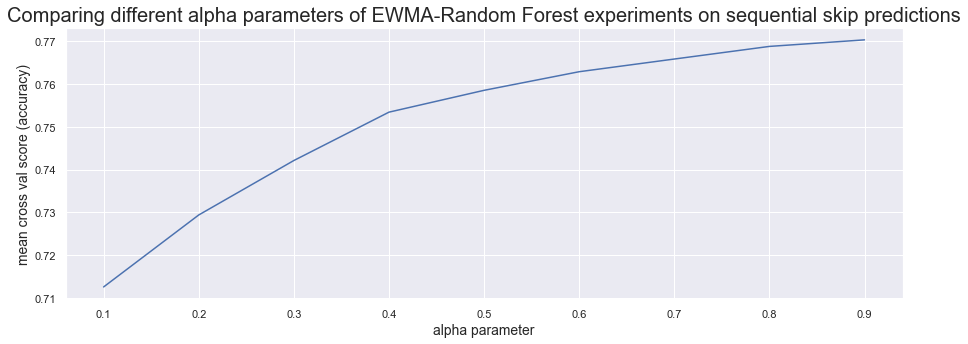

In [27]:
# Turns alpha parameter model accuracies to dataframe
alpha_acc_df = pd.DataFrame.from_dict(alpha_acc_dict).T

# Plots alpha parameter against mean validation score
plt.figure(figsize=(15,5))
plt.plot(alpha_acc_df)
plt.title('Comparing different alpha parameters of EWMA-Random Forest experiments on sequential skip predictions', size=20)
plt.xlabel('alpha parameter', size=14)
plt.ylabel('mean cross val score (accuracy)', size=14)
plt.xticks(alpha_acc_df.index)
plt.show()

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

### Using a Random Forest Classifier

In [29]:
# Takes about 3-4 minutes to run
# Assigning X
X3 = features

# Creates range of alpha values to iterate through
alpha_range = np.linspace(0.1, 0.9, 9).round(1) 

# Instantiates dictionary to store alpha parameter and respective accuracies from model
alpha_acc_dict = {}

# Pre-populates with keys from alpha_range
for i in alpha_range:
    alpha_acc_dict[i] = []

for alpha in alpha_range:
    
    print("Computing exponentially-weighted moving average for features.")
    X3 = X.groupby('session_id', as_index=False).ewm(alpha = alpha).mean().reset_index().drop('level_1', axis=1)

    # Assigns to X_shifted, will be re-assigned to original dataframe
    X3_shifted = X3.groupby('session_id')[['skip_2',   
                                                'enc__hist_user_behavior_reason_end_backbtn',
                                                'enc__hist_user_behavior_reason_end_clickrow',  
                                                'enc__hist_user_behavior_reason_end_endplay',  
                                                'enc__hist_user_behavior_reason_end_fwdbtn',  
                                                'enc__hist_user_behavior_reason_end_logout',
                                                'enc__hist_user_behavior_reason_end_remote',  
                                                'enc__hist_user_behavior_reason_end_trackdone']].shift()
    

    # Re-assigns previous columns to shift columns from above
    print("Implementing row stagger for skip and track end behaviour features.")

    X3 = X3.assign(**X3_shifted.to_dict(orient='series'))

    # Re-assigns 'session_position' to original value Re: I require the original values so that the model has information about where the track is within the session
    print("Re-assigning original 'session_position' feature values.")
    X3['session_position'] = X['session_position']

    # Drops first song from every session
    print("Dropping first song from every session.")
    X3.drop(X3[X3['session_position'] == 1].index, inplace=True)
    
    # Drops 'session_id' column
    print("Dropping 'session_id' column.")
    X3.drop('session_id', axis=1, inplace=True)
    
    estimators = [('random_forest_clf', RandomForestClassifier(n_jobs= -1, random_state=42))] 

    pipe = Pipeline(estimators)
    
    print("Calculating model score.")
    
    mean_cross_val_score = np.mean(cross_val_score(pipe, X3, y, cv=2, verbose=3))
    
    print("Appending score to dictionary.")
    alpha_acc_dict[alpha].append(mean_cross_val_score)

Computing exponentially-weighted moving average for features.
Implementing row stagger for skip and track end behaviour features.
Re-assigning original 'session_position' feature values.
Dropping first song from every session.
Dropping 'session_id' column.
Calculating model score.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.717) total time=   6.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s


[CV] END ................................ score: (test=0.715) total time=   6.5s
Appending score to dictionary.
Computing exponentially-weighted moving average for features.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.4s finished


Implementing row stagger for skip and track end behaviour features.
Re-assigning original 'session_position' feature values.
Dropping first song from every session.
Dropping 'session_id' column.
Calculating model score.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.741) total time=   6.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s


[CV] END ................................ score: (test=0.739) total time=   6.7s
Appending score to dictionary.
Computing exponentially-weighted moving average for features.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.4s finished


Implementing row stagger for skip and track end behaviour features.
Re-assigning original 'session_position' feature values.
Dropping first song from every session.
Dropping 'session_id' column.
Calculating model score.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.760) total time=   6.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV] END ................................ score: (test=0.759) total time=   6.9s
Appending score to dictionary.
Computing exponentially-weighted moving average for features.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.8s finished


Implementing row stagger for skip and track end behaviour features.
Re-assigning original 'session_position' feature values.
Dropping first song from every session.
Dropping 'session_id' column.
Calculating model score.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.773) total time=   6.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s


[CV] END ................................ score: (test=0.773) total time=   7.8s
Appending score to dictionary.
Computing exponentially-weighted moving average for features.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.8s finished


Implementing row stagger for skip and track end behaviour features.
Re-assigning original 'session_position' feature values.
Dropping first song from every session.
Dropping 'session_id' column.
Calculating model score.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.779) total time=   7.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.6s remaining:    0.0s


[CV] END ................................ score: (test=0.779) total time=   7.7s
Appending score to dictionary.
Computing exponentially-weighted moving average for features.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.4s finished


Implementing row stagger for skip and track end behaviour features.
Re-assigning original 'session_position' feature values.
Dropping first song from every session.
Dropping 'session_id' column.
Calculating model score.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.779) total time=   6.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s


[CV] END ................................ score: (test=0.780) total time=   7.2s
Appending score to dictionary.
Computing exponentially-weighted moving average for features.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.2s finished


Implementing row stagger for skip and track end behaviour features.
Re-assigning original 'session_position' feature values.
Dropping first song from every session.
Dropping 'session_id' column.
Calculating model score.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.780) total time=   6.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


[CV] END ................................ score: (test=0.780) total time=   7.3s
Appending score to dictionary.
Computing exponentially-weighted moving average for features.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.4s finished


Implementing row stagger for skip and track end behaviour features.
Re-assigning original 'session_position' feature values.
Dropping first song from every session.
Dropping 'session_id' column.
Calculating model score.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.779) total time=   6.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s


[CV] END ................................ score: (test=0.780) total time=   7.0s
Appending score to dictionary.
Computing exponentially-weighted moving average for features.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.1s finished


Implementing row stagger for skip and track end behaviour features.
Re-assigning original 'session_position' feature values.
Dropping first song from every session.
Dropping 'session_id' column.
Calculating model score.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.778) total time=   6.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV] END ................................ score: (test=0.779) total time=   6.6s
Appending score to dictionary.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.2s finished


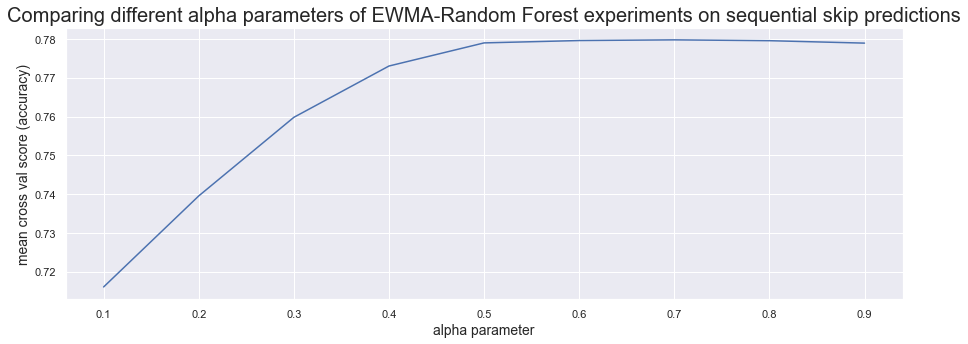

In [30]:
# Turns alpha parameter model accuracies to dataframe
alpha_acc_df = pd.DataFrame.from_dict(alpha_acc_dict).T

# Plots alpha parameter against mean validation score
plt.figure(figsize=(15,5))
plt.plot(alpha_acc_df)
plt.title('Comparing different alpha parameters of EWMA-Random Forest experiments on sequential skip predictions', size=20)
plt.xlabel('alpha parameter', size=14)
plt.ylabel('mean cross val score (accuracy)', size=14)
plt.xticks(alpha_acc_df.index)
plt.show()

In [31]:
alpha_acc_df

,0
0.1,0.716082
0.2,0.739543
0.3,0.759805
0.4,0.773030
0.5,0.778990
0.6,0.779598
0.7,0.779776
0.8,0.779560
0.9,0.778933


Based on the outputs above, as the moving average is calculated with more weight towards the current song, classification accuracy appears to increase as well. The figure along with the chart informs me that I should choose an alpha of 0.7 for my Random Forest Classifer. Which resulted in a mean 5-fold cross-validation score of 0.78.

## Wrapping Up
- My experiment with exponential-weighted moving average appears to have yield a slightly better classification accuracy as compared our baseline Logit model from the early notebooks
- These findings continue to substantiate the importance of previous feature history, but in the particular favouring more immediate or closer to present time
- When I weighted each song in the session equally as seen in the cumulative average experiment, there was far less predicting power as compared to the EWMA feature

---

# Next Steps:
- In the next and final notebook I will explore and evaluate the Random Forest classifier with the optimized alpha value
- I will discuss and reflect on how the results compared against my initial goals and hypothesis
- And see how the practical value of my project measures up against my initial expectation
- As well as potential next steps and future directions for the project